In [5]:
import json
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading Model

In [2]:
if "model" in locals():
    del model
    torch.cuda.empty_cache()
if "tokenizer" in locals():
    del tokenizer

path = "mistralai/Mistral-7B-v0.1"
model = AutoModelForCausalLM.from_pretrained(path)
model = model.half()
model = model.to(device)
tokenizer = AutoTokenizer.from_pretrained(path, padding_side="left")

tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


# Loading Data

In [3]:
with open("data/unexpected_contents.jsonl") as f:
    unexpected_contents = [json.loads(line) for line in f]

with open("data/unexpected_transfer.jsonl") as f:
    unexpected_transfer = [json.loads(line) for line in f]

In [4]:
tasks = []
for data in unexpected_contents + unexpected_transfer:
    for i in range(3):
        inp = {
            "input": data['prompts'][i],
            "target": data[f'target_{i+1}']
        }
        tasks.append(inp)

In [5]:
# Create a dataset from tasks list
dataset = Dataset.from_list(tasks).with_format("torch")

# Create a collate function to tokenize and pad the data
def collate_fn(examples):
    inputs = tokenizer(
        [ex["input"] for ex in examples],
        return_tensors="pt",
        padding=True,
        truncation=True,
    )
    if (
        model.config.architectures[0] == "GPT2LMHeadModel"
        or model.config.architectures[0] == "GPTNeoXForCausalLM"
        or model.config.architectures[0] == "GPTJForCausalLM"
    ):
        inputs["target"] = [tokenizer.encode(" " + ex["target"])[0] for ex in examples]
    elif model.config.architectures[0] == "LlamaForCausalLM" or model.config.architectures[0] == "LlaMAForCausalLM":
        inputs["target"] = [tokenizer.encode(ex["target"])[1] for ex in examples]
    elif model.config.architectures[0] == "MistralForCausalLM":
        inputs["target"] = [tokenizer.encode(" " + ex["target"])[2] for ex in examples]
    return inputs

# Create a DataLoader
dataloader = DataLoader(
    dataset, collate_fn=collate_fn, batch_size=1, shuffle=False
)

# Model Performance

In [7]:
correct, total = 0, 0
with torch.no_grad():
    for inp in tqdm(dataloader, total=len(dataloader)):
        inp["input_ids"] = inp["input_ids"].to(device)
        inp["attention_mask"] = inp["attention_mask"].to(device)

        outputs = model(inp["input_ids"])
        logits = outputs.logits
        predicted_ids = torch.argmax(logits[:, -1], dim=-1)

        for i, predicted_id in enumerate(predicted_ids):
            if predicted_id == inp["target"][i]:
                # print(f"{tokenizer.decode(predicted_id)} == {tokenizer.decode(inp['target'][i])}")
                correct += 1
            else:
                pass
                # print(f"{tokenizer.decode(predicted_id)} != {tokenizer.decode(inp['target'][i])}")
            total += 1

print(f"Accuracy: {correct/total:.2f}")

  1%|          | 4/549 [00:00<00:26, 20.95it/s]

beer == beer
wine == wine
beer != wine
audio == audio
video == video
audio != video


  2%|▏         | 11/549 [00:00<00:19, 27.24it/s]

ice == ice
jam == jam
jam == jam
salt == salt
sugar == sugar
sugar == sugar
pens == pens


  3%|▎         | 19/549 [00:00<00:18, 28.99it/s]

p == p
p == p
s == s
t == t
t == t
leaf == leaf


  5%|▍         | 25/549 [00:00<00:17, 29.27it/s]

rece == rece
leaf != rece
g == g
books == books
g != books
perf == perf


  6%|▌         | 31/549 [00:01<00:17, 29.10it/s]

water == water
water == water
coc == coc
her == her
her == her
tea == tea


  7%|▋         | 37/549 [00:01<00:17, 29.36it/s]

coffee == coffee
coffee == coffee
blood == blood
ur == ur
ur == ur
socks == socks


  8%|▊         | 44/549 [00:01<00:16, 29.81it/s]

scar == scar
scar == scar
videos == videos
photos == photos
photos == photos
wallet == wallet
sne == sne


  9%|▉         | 51/549 [00:01<00:16, 30.10it/s]

wallet != sne
sand == sand
beer == beer
beer == beer
clothes == clothes
vegetables == vegetables
vegetables == vegetables


 10%|█         | 55/549 [00:01<00:16, 30.13it/s]

jazz == jazz
disco == disco
disco == disco
lav == lav
sand == sand
sand == sand
chocolate == chocolate


 11%|█▏        | 63/549 [00:02<00:16, 30.28it/s]

pop == pop
pop == pop
beer == beer
beer == beer
beer == beer
audio == audio
audio == audio


 13%|█▎        | 71/549 [00:02<00:15, 30.33it/s]

audio == audio
ice == ice
ice == ice
jam != ice
salt == salt
salt == salt
salt == salt


 14%|█▍        | 79/549 [00:02<00:15, 30.24it/s]

pens == pens
p != pens
pens == pens
s == s
t != s
s == s
leaf == leaf


 15%|█▌        | 83/549 [00:02<00:15, 30.08it/s]

leaf == leaf
leaf == leaf
g == g
g == g
g == g
water != perf


 17%|█▋        | 91/549 [00:03<00:15, 29.98it/s]

water != perf
perf == perf
coc == coc
her != coc
coc == coc
tea == tea
coffee != tea


 18%|█▊        | 98/549 [00:03<00:14, 30.34it/s]

tea == tea
blood == blood
blood == blood
blood == blood
scar != socks
socks == socks
socks == socks


 19%|█▉        | 106/549 [00:03<00:14, 30.43it/s]

videos == videos
videos == videos
videos == videos
wallet == wallet
wallet == wallet
wallet == wallet
sand == sand


 20%|██        | 110/549 [00:03<00:14, 30.34it/s]

beer != sand
beer != sand
clothes == clothes
clothes == clothes
clothes == clothes
jazz == jazz
jazz == jazz


 21%|██▏       | 118/549 [00:03<00:14, 30.29it/s]

jazz == jazz
sand != lav
sand != lav
lav == lav
chocolate == chocolate
chocolate == chocolate


 23%|██▎       | 126/549 [00:04<00:13, 30.25it/s]

chocolate == chocolate
beer == beer
orange != beer
beer == beer
ice == ice
jam != ice
jam != ice


 24%|██▎       | 130/549 [00:04<00:13, 30.26it/s]

salt == salt
sugar != salt
sugar != salt
pens == pens
p != pens
p != pens
s == s


 25%|██▌       | 138/549 [00:04<00:13, 30.15it/s]

t != s
t != s
leaf == leaf
rece != leaf
leaf == leaf
g == g
books != g


 27%|██▋       | 146/549 [00:04<00:13, 30.19it/s]

g == g
milk == milk
water != milk
water != milk
coc == coc
her != coc
her != coc


 28%|██▊       | 154/549 [00:05<00:13, 30.15it/s]

tea == tea
coffee != tea
coffee != tea
blood == blood
ur != blood
ur != blood
socks == socks


 29%|██▉       | 158/549 [00:05<00:12, 30.51it/s]

scar != socks
scar != socks
wallet == wallet
sne != wallet
wallet == wallet
sand == sand
beer != sand


 30%|███       | 166/549 [00:05<00:12, 30.39it/s]

beer != sand
clothes == clothes
vegetables != clothes
vegetables != clothes
chocolate == chocolate
pop != chocolate
pop != chocolate


 32%|███▏      | 174/549 [00:05<00:12, 30.35it/s]

beer == beer
beer == beer
beer == beer
audio == audio
video != audio
audio == audio
ice == ice


 33%|███▎      | 182/549 [00:06<00:12, 30.25it/s]

ice == ice
jam != ice
salt == salt
sugar != salt
sugar != salt
pens == pens
pens == pens


 34%|███▍      | 186/549 [00:06<00:11, 30.26it/s]

p != pens
s == s
t != s
t != s
leaf == leaf
rece != leaf


 35%|███▌      | 194/549 [00:06<00:11, 29.85it/s]

leaf == leaf
g == g
books != g
g == g
perf == perf
water != perf
water != perf


 37%|███▋      | 202/549 [00:06<00:11, 30.13it/s]

coc == coc
coc == coc
her != coc
tea == tea
coffee != tea
coffee != tea
blood == blood


 38%|███▊      | 206/549 [00:06<00:11, 30.09it/s]

ur != blood
blood == blood
videos == videos
photos != videos
photos != videos
wallet == wallet
sne != wallet


 39%|███▉      | 214/549 [00:07<00:11, 29.89it/s]

wallet == wallet
sand == sand
beer != sand
beer != sand
clothes == clothes
vegetables != clothes


 40%|████      | 222/549 [00:07<00:10, 30.29it/s]

vegetables != clothes
CD != jazz
disco != jazz
disco != jazz
lav == lav
sand != lav
sand != lav


 41%|████      | 226/549 [00:07<00:10, 30.38it/s]

chocolate == chocolate
pop != chocolate
pop != chocolate
beer == beer
beer == beer
beer == beer
audio == audio


 43%|████▎     | 234/549 [00:07<00:10, 30.26it/s]

audio == audio
audio == audio
ice == ice
ice == ice
jam != ice
salt == salt
salt == salt


 44%|████▍     | 242/549 [00:08<00:10, 30.17it/s]

salt == salt
pens == pens
p != pens
p != pens
s == s
s == s


 45%|████▍     | 246/549 [00:08<00:10, 28.08it/s]

s == s
leaf == leaf
rece != leaf
leaf == leaf
g == g
g == g


 46%|████▌     | 252/549 [00:08<00:10, 28.82it/s]

g == g
water != perf
water != perf
water != perf
her != coc
coc == coc


 47%|████▋     | 258/549 [00:08<00:10, 27.99it/s]

coc == coc
tea == tea
coffee != tea
coffee != tea
blood == blood
blood == blood


 48%|████▊     | 265/549 [00:08<00:09, 29.26it/s]

blood == blood
socks == socks
scar != socks
socks == socks
photos != videos
videos == videos
photos != videos


 49%|████▉     | 271/549 [00:09<00:10, 26.71it/s]

wallet == wallet
sne != wallet
wallet == wallet
sand == sand
beer != sand


 50%|█████     | 277/549 [00:09<00:09, 27.63it/s]

beer != sand
clothes == clothes
vegetables != clothes
clothes == clothes
jazz == jazz
jazz == jazz
jazz == jazz


 52%|█████▏    | 283/549 [00:09<00:09, 28.50it/s]

lav == lav
sand != lav
sand != lav
chocolate == chocolate
pop != chocolate
chocolate == chocolate


 53%|█████▎    | 289/549 [00:09<00:08, 29.03it/s]

beer == beer
wine != beer
wine != beer
audio == audio
video != audio
video != audio
ice == ice


 54%|█████▍    | 297/549 [00:10<00:08, 29.72it/s]

jam != ice
jam != ice
pens == pens
p != pens
p != pens
s == s
t != s


 55%|█████▌    | 303/549 [00:10<00:08, 29.68it/s]

t != s
leaf == leaf
rece != leaf
leaf == leaf
perf == perf
water != perf


 56%|█████▋    | 309/549 [00:10<00:08, 29.81it/s]

water != perf
tea == tea
coffee != tea
coffee != tea
socks == socks
scar != socks
scar != socks


 58%|█████▊    | 317/549 [00:10<00:07, 30.21it/s]

videos == videos
photos != videos
photos != videos
m != keyboard
m != keyboard
m != keyboard
sand == sand


 59%|█████▉    | 325/549 [00:10<00:07, 30.14it/s]

beer != sand
beer != sand
jazz == jazz
disco != jazz
disco != jazz
lav == lav
sand != lav


 60%|█████▉    | 329/549 [00:11<00:07, 29.95it/s]

lav == lav
chocolate == chocolate
pop != chocolate
pop != chocolate
yellow == yellow


 61%|██████    | 335/549 [00:11<00:08, 25.12it/s]

red == red
red == red
cup == cup
drawer == drawer
drawer == drawer


 62%|██████▏   | 341/549 [00:11<00:08, 23.42it/s]

Ed != Ed
D != D
D != D
shed == shed
house == house


 63%|██████▎   | 347/549 [00:11<00:08, 25.12it/s]

house == house
fence == fence
shed == shed
shed == shed
basket == basket
box == box


 64%|██████▍   | 354/549 [00:12<00:07, 27.67it/s]

box == box
green == green
blue == blue
going != blue
basket != laundry
washing == washing
washing == washing


 66%|██████▌   | 361/549 [00:12<00:06, 29.19it/s]

broken == broken
broken != rep
: != rep
free == free
fr == fr
fr == fr
reception == reception


 66%|██████▋   | 364/549 [00:12<00:06, 28.84it/s]

conference == conference
conference == conference
savings != checking
savings == savings
savings == savings


 67%|██████▋   | 370/549 [00:12<00:07, 24.88it/s]

blue != green
blue == blue
blue == blue
Oxford == Oxford
Not == Not


 68%|██████▊   | 376/549 [00:13<00:07, 24.29it/s]

Not == Not
Finance != Internal
Finance == Finance
Finance == Finance
A != Armen


 69%|██████▉   | 379/549 [00:13<00:07, 23.44it/s]

A == A
A == A
templates != templates
docs != doc


 70%|███████   | 385/549 [00:13<00:07, 22.89it/s]

docs != doc
right == right
left == left
left == left
Y == Y
X == X


 71%|███████   | 389/549 [00:13<00:06, 25.20it/s]

X == X
box == box
basket == basket
basket == basket
right == right


 72%|███████▏  | 395/549 [00:13<00:07, 21.72it/s]

left != right
left != right
cup == cup
drawer != cup


 72%|███████▏  | 398/549 [00:14<00:07, 20.39it/s]

drawer != cup
Ed != Ed
D != Ed
D != Ed


 74%|███████▎  | 404/549 [00:14<00:06, 22.23it/s]

shed == shed
house != shed
house != shed
fence == fence
shed != fence
shed != fence


 75%|███████▍  | 410/549 [00:14<00:05, 24.78it/s]

box != basket
box != basket
box != basket
dry == dry
washing != dry
washing != dry


 76%|███████▌  | 417/549 [00:14<00:04, 27.51it/s]

broken == broken
broken == broken
broken == broken
free == free
fr != free
fr != free


 77%|███████▋  | 420/549 [00:14<00:05, 21.94it/s]

templates != templates
docs != templates
docs != templates
Y == Y


 78%|███████▊  | 427/549 [00:15<00:04, 24.43it/s]

X != Y
X != Y
box == box
chest != box
chest != box
red != yellow


 78%|███████▊  | 430/549 [00:15<00:04, 23.86it/s]

red != yellow
red != yellow
counter != cup
shelf != cup
shelf != cup


 79%|███████▉  | 436/549 [00:15<00:04, 25.51it/s]

box != basket
box != basket
box != basket
couch != sofa
couch != sofa
couch != sofa


 81%|████████  | 442/549 [00:15<00:04, 25.91it/s]

blue != green
blue != green
blue != green
Y == Y
X != Y
X != Y


 82%|████████▏ | 449/549 [00:16<00:04, 24.38it/s]

box == box
basket != box
basket != box
yellow == yellow
red != yellow


 82%|████████▏ | 452/549 [00:16<00:04, 23.21it/s]

red != yellow
cup == cup
drawer != cup
drawer != cup
Ed != Ed


 83%|████████▎ | 458/549 [00:16<00:04, 21.79it/s]

D != Ed
D != Ed
shed == shed
house != shed
house != shed


 85%|████████▍ | 464/549 [00:16<00:03, 23.59it/s]

neighbor != fence
neighbor != fence
one != fence
basket == basket
box != basket
box != basket


 86%|████████▌ | 472/549 [00:16<00:02, 27.04it/s]

green == green
blue != green
going != green
dry != laundry
washing != laundry
washing != laundry
broken == broken


 87%|████████▋ | 476/549 [00:17<00:02, 27.93it/s]

broken == broken
broken == broken
free == free
fr != free
fr != free
conference != reception
conference != reception


 88%|████████▊ | 483/549 [00:17<00:02, 26.88it/s]

conference != reception
savings != checking
checking == checking
savings != checking
Oxford == Oxford


 89%|████████▉ | 489/549 [00:17<00:02, 25.98it/s]

Oxford == Oxford
Not != Oxford
Finance != Internal
Finance != Internal
Finance != Internal
A != Armen


 90%|████████▉ | 492/549 [00:17<00:02, 26.09it/s]

A != Armen
A != Armen
templates != templates
docs != templates


 91%|█████████ | 498/549 [00:18<00:02, 24.41it/s]

docs != templates
Y == Y
X != Y
X != Y
box == box
basket != box


 92%|█████████▏| 504/549 [00:18<00:01, 24.16it/s]

basket != box
yellow == yellow
red != yellow
: != yellow
drawer != cup


 93%|█████████▎| 510/549 [00:18<00:01, 23.12it/s]

drawer != cup
drawer != cup
D != Ed
D != Ed
D != Ed


 94%|█████████▍| 516/549 [00:18<00:01, 26.00it/s]

shed == shed
shed == shed
house != shed
basket == basket
box != basket
box != basket


 95%|█████████▍| 520/549 [00:18<00:01, 27.35it/s]

green == green
green == green
going != green
washing != laundry
washing != laundry
washing != laundry
now != broken


 96%|█████████▌| 527/549 [00:19<00:00, 28.62it/s]

broken == broken
broken == broken
free == free
free == free
fr != free
conference != reception


 97%|█████████▋| 533/549 [00:19<00:00, 28.83it/s]

conference != reception
conference != reception
savings != checking
checking == checking
savings != checking
Oxford != Not


 98%|█████████▊| 539/549 [00:19<00:00, 26.85it/s]

Oxford != Not
Not == Not
Finance != Internal
Finance != Internal
Finance != Internal


 99%|█████████▉| 545/549 [00:19<00:00, 24.02it/s]

templates != templates
docs != templates
templates != templates
X != Y
X != Y


100%|██████████| 549/549 [00:19<00:00, 27.48it/s]

X != Y
box == box
basket != box
basket != box
Accuracy: 0.53


# Visualizing Model Performance

In [17]:
with open("results.json", "r") as f:
    results = json.load(f)

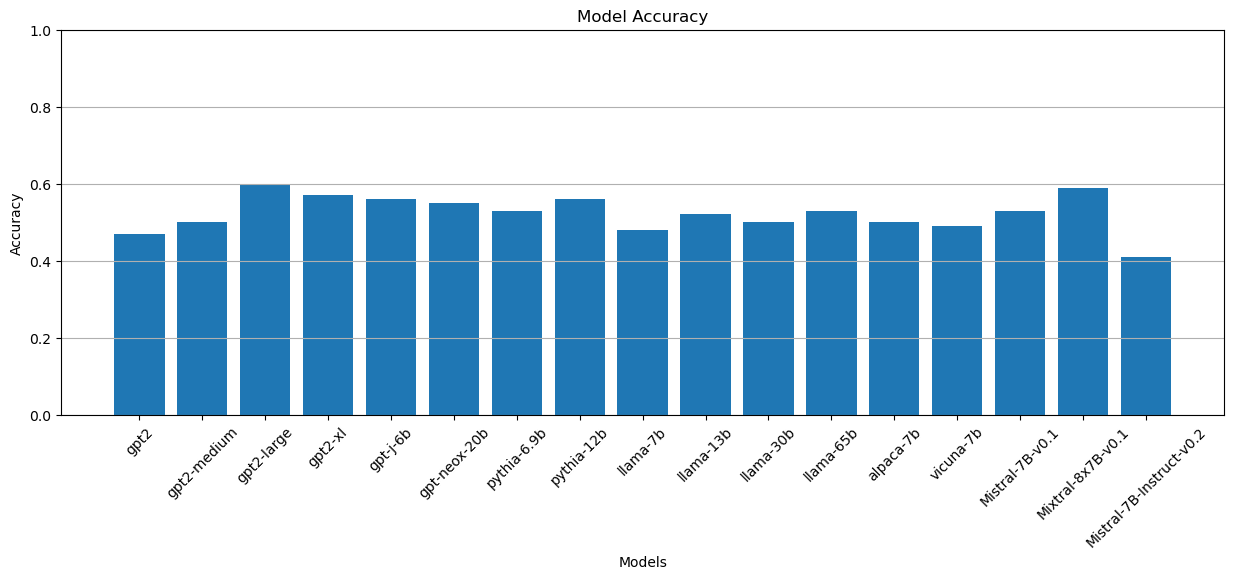

In [18]:
# plot figure size
plt.figure(figsize=(15, 5))
plt.bar(results.keys(), results.values())
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()